### Tests
Use of the agglomerative clustering with HR diagram.

We test here metrics to detect good solutions for clustering

In [1]:
import sys, os
sys.path.append('../../src')

from numba import jit

import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import pickle

from math import ceil
import math
import gaia_utils as gu
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from astroML.correlation import two_point
from astroML.correlation import bootstrap_two_point_angular

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)
rcParams['figure.figsize'] = 9, 6
###################################

clustername = "NGC 1647"
# voname = 'NGC 752-1.0deg.vot'
# voname = 'NGC 2682-3.0deg.vot'
voname = 'NGC 1647-2.0deg.vot'
# voname = "Ruprecht 1-2.0deg.vot"
RADIUS   = 2.0
kCluster = 8
votable_disk = False
distclust = 572.0
WEIGHT = [3.,3.,11.,5.,5., 2., 2., 2.]
WEIGHT = [4.87863010104081, 4.87863010104081, 4.306272782136562, 2.5786331381796077, 2.5786331381796077, 1.4117964989460319, 1.4117964989460319, 1.4117964989460319]

## dscan
eps = 1.5
min_samples = 20
## Ward
neighbors = 30

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
## plot2D and plot3D


def plot2d(df, labels, ilab, cmap = "gist_stern" ,color = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if color:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c = "k")
    axarr[0,0].set_xlabel("l")
    axarr[0,0].set_ylabel("b")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),2] , s=0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,0].set_xlabel("l")
    axarr[1,0].set_ylabel("d (pc)")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-1.,1.5)
    axarr[1,1].set_ylim(27.,10)
    
    plt.show()
    

In [3]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist, offCenter = [0., 0.]):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    lgalOff = lgal - offCenter[0]
    bgalOff = bgal - offCenter[1]
    
    print(offCenter[0])
    print(offCenter[1])
    print(min(lgalOff))
    print(max(lgalOff))
    print(min(bgalOff))
    print(max(bgalOff))
    
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    print("## XX")
    print("min, max: %f , %f"%(min(xx),max(xx)))
    print("## YY")
    print("min, max: %f , %f"%(min(yy),max(yy)))
    print("## ZZ")
    print("min, max: %f , %f"%(min(zz),max(zz)))  
        
    return(xx,yy,zz)

In [4]:
## Read the data and do the conversion


source = gu.source(clustername)
source.weight = WEIGHT
#source.query(RADIUS, errtol = 0.2, dump = True)
source.read_votable(voname)
source.convert_filter_data(mag_range = [0., 40])
source.normalization_normal()
#source.normalization_minmax()

## NGC 1647-2.0deg.vot read...
## Total stars: 20719
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..


()

### Metrics

Metric to quantify goodness-of-solution for the clustering.

In [5]:
def metric1(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP =20 ):
    "Using the density contrat assuming the OC is at the center"
    
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        Q_c = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            dens_out_k = max(1,len(nout)) / aper2
            Q_c[k] = dens_clust / dens_out_k
            
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)
                          
    
def metric2(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP = 50 , SIGCLIP = 0.):
    "Using the density contrat assuming the OC is at the center and the distribution around is regular (no holes)"
        
    epsilon = 0.1
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        nstarsout = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            nstarsout[k] = len(nout) + np.random.uniform(1., 1.+ epsilon)
                
        outmean = np.mean(nstarsout)
        outstd  = np.std(nstarsout)
        
        nstar_filtered = np.where( (nstarsout - outmean)/ outstd > SIGCLIP )

        dens_out = nstarsout[nstar_filtered] / aper2
        Q_c = np.zeros(len(dens_out))
        Q_c = dens_clust / dens_out
        
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)                      

In [6]:
def iter_parameters(angmin,angmax,dmin,dmax,vmin,vmax,magmin,magmax, kmin, kmax ,ntrial, von = "test.vot", radius = 1):
    "Range of the weight for each group of parameters"
        
    s = gu.source(clustername)
    s.read_votable(von)

    metric = {}
    angle = np.linspace(angmin,angmax,ntrial)
    distance = np.linspace(dmin,dmax,ntrial)
    vel   = np.linspace(vmin, vmax,ntrial)
    mag   = np.linspace(magmin, magmax,ntrial)
    kclus = range(kmin,kmax)
    
    metric['kmeans'] = {}
    metric['kmeans']['weight'] = []
    metric['kmeans']['metric'] = []
                            
                            
    for a in angle:
        for v in vel:
            for m in mag:
                for d in distance:
                    for k in kclus:
                        WEIGHT = [a,a,d,v,v,m,m,m] 
                        s.weight = WEIGHT
                        s.convert_filter_data(mag_range = [0., 40])
                        s.normalization_normal()
    
                        print(WEIGHT)
        
                        kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
                        kmeans.fit(s.dfnorm)
                        labels_k = kmeans.labels_
                        qk = metric1(s.df, labels_k, APERTURE = 0.2 , MAXRADIUS = radius , NBOOTSTRAP =10 )
                        metric['kmeans']['weight'].append(WEIGHT)
                        metric['kmeans']['metric'].append(qk)
                            
        
    return(metric)


def random_weighting(angmin,angmax,dmin,dmax,vmin,vmax,magmin,magmax, kmin, kmax , von = "test.vot", radius = 1, NBOOTSTRAP = 100, SCAN = None):
    "Sample with NBOOTSTRAP trial in the weight range to get the Q"
    
    np.random.seed()
    
    s = gu.source(clustername)
    s.read_votable(von)
    
    aper = 0.5
    
    if SCAN == None:
        metric = {}
        metric['kmeans'] = {}
        metric['kmeans']['weight'] = []
        metric['kmeans']['metric'] = []
        metric['ward'] = {}
        metric['ward']['weight'] = []
        metric['ward']['metric'] = []
        metric['spectral'] = {}
        metric['spectral']['weight'] = []
        metric['spectral']['metric'] = []
        metric['dbscan'] = {}
        metric['dbscan']['weight'] = []
        metric['dbscan']['metric'] = []
    else:
        print("## Adding to the previous metric ...")
        metric = SCAN
        
    
    angle     = np.random.uniform(angmin, angmax, NBOOTSTRAP)
    distance  = np.random.uniform(dmin, dmax, NBOOTSTRAP)
    velocity  = np.random.uniform(vmin, vmax, NBOOTSTRAP)
    magnitude = np.random.uniform(magmin, magmax, NBOOTSTRAP)
    ncluster  = np.random.randint(kmin, kmax, NBOOTSTRAP)
    
            
    for i in range(NBOOTSTRAP):
        WEIGHT = [angle[i],angle[i],distance[i],velocity[i],velocity[i], magnitude[i],magnitude[i], magnitude[i]]
        nclust = ncluster[i]
        
        s.weight = WEIGHT
        s.convert_filter_data(mag_range = [0., 40])
        s.normalization_normal()
    
        print(WEIGHT)
        print(i)
        
        # kmeans
        kmeans = cluster.KMeans(n_clusters= nclust, max_iter = 2000, n_init = 50)
        kmeans.fit(s.dfnorm)
        labels_k = kmeans.labels_
        qk = metric2(s.df, labels_k, APERTURE = aper , MAXRADIUS = 0.9 * radius , NBOOTSTRAP =50 )
        metric['kmeans']['weight'].append(WEIGHT)
        metric['kmeans']['metric'].append(qk)
        print("## Best Q: %3.1f"%(max(qk['Q'])))
        print("# k-means done")
                            
        # ward
        connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)
        ward = cluster.AgglomerativeClustering(n_clusters= nclust, linkage='ward', connectivity=connectivity)
        ward.fit(s.dfnorm)
        labels_w = ward.labels_
        qw = metric2(s.df, labels_w, APERTURE = aper , MAXRADIUS = 0.9 * radius , NBOOTSTRAP =50 )
        metric['ward']['weight'].append(WEIGHT)
        metric['ward']['metric'].append(qw)
        print("## Best Q: %3.1f"%(max(qw['Q'])))        
        print("# Ward done")
        
        # Spectral
        spectral = cluster.SpectralClustering(n_clusters = nclust, eigen_solver='arpack', affinity="nearest_neighbors")
        # spectral.fit(s.dfnorm) !!!!
        # !!!!!!
        print("# !!! Spectral = Ward")
        labels_s = ward.labels_
        #!!!!!!!
        qs = metric2(s.df, labels_s, APERTURE = aper , MAXRADIUS = 0.9 * radius , NBOOTSTRAP =50 )
        metric['spectral']['weight'].append(WEIGHT)
        metric['spectral']['metric'].append(qs)
        print("## Best Q: %3.1f"%(max(qs['Q'])))        
        print("# Spectral done")
        
        # DBSCAN
        dbscan = cluster.DBSCAN(eps = eps, min_samples = min_samples)
        dbscan.fit(s.dfnorm)
        labels_d = dbscan.labels_
        unique_labels = set(labels_d)
        print(unique_labels)
        n_clusters_ = len(set(labels_d)) - (1 if -1 in labels_d else 0)
        if n_clusters_ > 0:
            qd = metric2(s.df, labels_d, APERTURE = aper , MAXRADIUS = 0.9 * radius , NBOOTSTRAP =50 )
            for i in range(max(labels_d)+1):
                print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
            print("##")
        else:
            qd = {}
            qd['Q'] = [0., 0.]
            qd['Q_err'] = [0.,0.]
            qd['label'] = [0,1]

        metric['dbscan']['weight'].append(WEIGHT)
        metric['dbscan']['metric'].append(qd)
        print("## Best Q: %3.1f"%(max(qd['Q'])))
        print("# DBSCAN done")
            
    return(metric)       
    

### Clustering

In [7]:
## testing loop on parameters ..
## Could be very long!!!
## To continue a previous scan..
with open('dataQran.pickle', 'rb') as f:
    previousMetric = pickle.load(f)

# q = iter_parameters(2.,5.,7.,12.,2.,4.,1.,3., 7,8 ,2, von = voname, radius = 2.)
q = random_weighting(1.,7.,3.,15.,1.,7.,1.,6., 5 ,12 , von = voname, radius = 2., NBOOTSTRAP = 450, 
                     SCAN = previousMetric)

with open('dataQran.pickle', 'wb') as f:
    pickle.dump(q, f, pickle.HIGHEST_PROTOCOL)

## NGC 1647-2.0deg.vot read...
## Total stars: 20719
## Adding to the previous metric ...
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.7199086104859145, 3.7199086104859145, 7.339042676418221, 4.1763276647036065, 4.1763276647036065, 4.5486170624770885, 4.5486170624770885, 4.5486170624770885]
0
## Best Q: 1.7
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 2.0
# Spectral done
{0, 1, -1}
# Label     0 :   151  Dist:  592.6 ( 27.7)
# Label     1 :    31  Dist:  595.7 ( 20.7)
##
## Best Q: 5.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.159662618453153, 6.159662618453153, 11.175290310067167, 6.6281609862688855, 6.6281609862688855, 1.0947650463166165, 1.0947650463166165, 1.0947650463166165]
1
## Best Q: 1.0
# k-means done
## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :   275  Dis

## Best Q: 1.6
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, 1, -1}
# Label     0 :   185  Dist:  594.3 ( 24.7)
# Label     1 :    49  Dist:  594.7 ( 18.8)
##
## Best Q: 4.3
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.4016570524294347, 3.4016570524294347, 10.783805247675469, 4.241951622362366, 4.241951622362366, 3.791558014371417, 3.791558014371417, 3.791558014371417]
18
## Best Q: 1.8
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{0, -1}
# Label     0 :   229  Dist:  594.3 ( 23.0)
##
## Best Q: 3.9
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.7590514867661815, 6.7590514867661815, 6.176700381800977, 6.315838004250003, 6.315838004250003, 4.120397185650782, 4.120397185650782, 4.120397185650782]
19
## Best Q: 1.7
# k-means done
## Best Q: 1.2
#

## Best Q: 1.5
# k-means done
## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{0, 1, -1}
# Label     0 :   209  Dist:  595.5 ( 31.5)
# Label     1 :    52  Dist:  596.2 ( 21.6)
##
## Best Q: 3.8
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.622752478953844, 1.622752478953844, 3.0622080864661685, 6.146242031213872, 6.146242031213872, 4.142013436069542, 4.142013436069542, 4.142013436069542]
37
## Best Q: 2.0
# k-means done
## Best Q: 2.1
# Ward done
# !!! Spectral = Ward
## Best Q: 2.1
# Spectral done
{0, -1}
# Label     0 :   449  Dist:  595.1 ( 38.2)
##
## Best Q: 3.4
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.380418131471506, 6.380418131471506, 8.985867346813311, 6.231628335617424, 6.231628335617424, 3.731128955465765, 3.731128955465765, 3.731128955465765]
38
## Best Q: 1.9
# k-means done
## Best Q: 2.3
# War

## Best Q: 1.8
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, 1, 2, -1}
# Label     0 :   650  Dist:  596.0 ( 36.5)
# Label     1 :    20  Dist:  685.7 ( 24.0)
# Label     2 :    20  Dist: 1357.5 ( 21.1)
##
## Best Q: 2.5
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.2848041537099726, 1.2848041537099726, 12.230697243037541, 2.2386485892061705, 2.2386485892061705, 5.58886113053121, 5.58886113053121, 5.58886113053121]
54
## Best Q: 1.8
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 1.9
# Spectral done
{0, -1}
# Label     0 :   361  Dist:  595.2 ( 25.2)
##
## Best Q: 3.3
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.8565571969114307, 2.8565571969114307, 13.45966154153139, 5.249313636132122, 5.249313636132122, 3.1504122755921125, 3.1504122755921125, 3.1504122755921125]


## Best Q: 1.3
# k-means done
## Best Q: 1.4
# Ward done
# !!! Spectral = Ward
## Best Q: 1.4
# Spectral done
{0, 1, -1}
# Label     0 :   453  Dist:  595.2 ( 41.7)
# Label     1 :    25  Dist:  605.3 ( 50.9)
##
## Best Q: 2.9
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.9370602404117103, 1.9370602404117103, 14.951443442460508, 6.542102018718784, 6.542102018718784, 1.7903788590234746, 1.7903788590234746, 1.7903788590234746]
72
## Best Q: 1.6
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Label     0 :   445  Dist:  595.8 ( 25.6)
##
## Best Q: 3.8
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.008629574352699, 6.008629574352699, 8.698522121426349, 6.915220523582551, 6.915220523582551, 4.597882536562375, 4.597882536562375, 4.597882536562375]
73
## Best Q: 1.6
# k-means done
## Best Q: 2.2


## Best Q: 1.5
# k-means done
## Best Q: 1.4
# Ward done
# !!! Spectral = Ward
## Best Q: 1.3
# Spectral done
{0, -1}
# Label     0 :   247  Dist:  594.3 ( 28.2)
##
## Best Q: 4.3
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.117115068307543, 2.117115068307543, 14.727357323623234, 2.877492536959792, 2.877492536959792, 3.0838258528440576, 3.0838258528440576, 3.0838258528440576]
90
## Best Q: 1.7
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :   371  Dist:  594.2 ( 23.5)
##
## Best Q: 3.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.592385385435355, 6.592385385435355, 11.400192604625836, 3.5532740835934993, 3.5532740835934993, 2.643923232598694, 2.643923232598694, 2.643923232598694]
91
## Best Q: 1.5
# k-means done
## Best Q: 2.0
# Ward done
# !!! Spectral = Ward
## Best Q: 2

## Best Q: 0.6
# k-means done
## Best Q: 1.3
# Ward done
# !!! Spectral = Ward
## Best Q: 1.3
# Spectral done
{0, -1}
# Label     0 :   220  Dist:  593.2 ( 25.8)
##
## Best Q: 4.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.7741988476460184, 1.7741988476460184, 11.390190635762051, 6.9674097521508465, 6.9674097521508465, 4.380899215371338, 4.380899215371338, 4.380899215371338]
108
## Best Q: 1.8
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 2.2
# Spectral done
{0, -1}
# Label     0 :   316  Dist:  594.3 ( 23.7)
##
## Best Q: 3.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.3716909778890587, 2.3716909778890587, 3.7393424399505983, 2.3819162600959105, 2.3819162600959105, 5.383521524930663, 5.383521524930663, 5.383521524930663]
109
## Best Q: 1.5
# k-means done
## Best Q: 1.4
# Ward done
# !!! Spectral = Ward
## Best

## Best Q: 1.7
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, 1, -1}
# Label     0 :   139  Dist:  592.7 ( 25.3)
# Label     1 :    20  Dist:  595.2 ( 17.4)
##
## Best Q: 5.1
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.470521333824657, 5.470521333824657, 11.704510939523876, 6.664569909383996, 6.664569909383996, 1.3774669882594979, 1.3774669882594979, 1.3774669882594979]
126
## Best Q: 1.9
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Label     0 :   275  Dist:  593.6 ( 23.0)
##
## Best Q: 5.1
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.4216486972184452, 1.4216486972184452, 4.0248419138766085, 5.647173746341058, 5.647173746341058, 1.1779037429621404, 1.1779037429621404, 1.1779037429621404]
127
## Best Q: 2.1
# k-means done
## Best Q

## Best Q: 1.4
# k-means done
## Best Q: 1.4
# Ward done
# !!! Spectral = Ward
## Best Q: 1.4
# Spectral done
{0, 1, -1}
# Label     0 :   197  Dist:  594.2 ( 31.4)
# Label     1 :    39  Dist:  595.9 ( 21.7)
##
## Best Q: 4.5
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.3619109679027273, 2.3619109679027273, 7.647603969948524, 4.430990708500937, 4.430990708500937, 4.948085942175808, 4.948085942175808, 4.948085942175808]
144
## Best Q: 1.7
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :   277  Dist:  594.3 ( 27.8)
##
## Best Q: 6.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.126185535999223, 5.126185535999223, 14.337383260649487, 2.152169193716157, 2.152169193716157, 1.6616430664322386, 1.6616430664322386, 1.6616430664322386]
145
## Best Q: 1.2
# k-means done
## Best Q: 1.

## Best Q: 1.9
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, 1, -1}
# Label     0 :    47  Dist:  595.1 ( 21.8)
# Label     1 :    25  Dist:  599.1 ( 23.6)
##
## Best Q: 4.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.0471944733246235, 1.0471944733246235, 10.526972133012443, 5.200548382749343, 5.200548382749343, 5.474493654308047, 5.474493654308047, 5.474493654308047]
161
## Best Q: 1.6
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   351  Dist:  594.3 ( 26.3)
##
## Best Q: 3.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.851620294272461, 6.851620294272461, 13.049110254503253, 2.6215075967098427, 2.6215075967098427, 1.3429271295563452, 1.3429271295563452, 1.3429271295563452]
162
## Best Q: 1.0
# k-means done
## Best Q:

## Best Q: 0.9
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Label     0 :   161  Dist:  593.6 ( 28.1)
##
## Best Q: 6.9
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.452197161237534, 5.452197161237534, 14.183671414353226, 3.3241645407352287, 3.3241645407352287, 1.0528732190086418, 1.0528732190086418, 1.0528732190086418]
179
## Best Q: 1.8
# k-means done
## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{0, -1}
# Label     0 :   328  Dist:  594.3 ( 23.4)
##
## Best Q: 4.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.682922965728468, 5.682922965728468, 5.319779990505284, 4.551293534323577, 4.551293534323577, 4.241522946036089, 4.241522946036089, 4.241522946036089]
180
## Best Q: 1.3
# k-means done
## Best Q: 1.2
# Ward done
# !!! Spectral = Ward
## Best Q: 

## Best Q: 1.2
# Ward done
# !!! Spectral = Ward
## Best Q: 1.2
# Spectral done
{0, -1}
# Label     0 :    88  Dist:  594.5 ( 22.1)
##
## Best Q: 7.1
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.144131583397528, 1.144131583397528, 8.320962094688415, 3.1877438709119392, 3.1877438709119392, 2.5726668570657947, 2.5726668570657947, 2.5726668570657947]
197
## Best Q: 1.8
# k-means done
## Best Q: 2.0
# Ward done
# !!! Spectral = Ward
## Best Q: 1.9
# Spectral done
{0, -1}
# Label     0 :   603  Dist:  596.2 ( 34.8)
##
## Best Q: 3.5
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.106670141727573, 4.106670141727573, 6.9839063034504125, 6.700787547139336, 6.700787547139336, 4.537178800959264, 4.537178800959264, 4.537178800959264]
198
## Best Q: 1.7
# k-means done
## Best Q: 2.1
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# 

## Best Q: 1.6
# k-means done
## Best Q: 2.2
# Ward done
# !!! Spectral = Ward
## Best Q: 2.3
# Spectral done
{0, -1}
# Label     0 :    28  Dist:  597.0 ( 21.0)
##
## Best Q: 8.3
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.156110595205023, 5.156110595205023, 3.6478091650846958, 3.833869196676722, 3.833869196676722, 4.2269103079019645, 4.2269103079019645, 4.2269103079019645]
215
## Best Q: 1.6
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Label     0 :    90  Dist:  592.6 ( 30.4)
##
## Best Q: 7.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.5443623533858013, 1.5443623533858013, 7.931614359458733, 3.365016883682421, 3.365016883682421, 4.182557101850915, 4.182557101850915, 4.182557101850915]
216
## Best Q: 1.7
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 

## Best Q: 1.1
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 2.0
# Spectral done
{-1}
## Best Q: 0.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.184619446670097, 5.184619446670097, 14.924689610479575, 1.6667411535246, 1.6667411535246, 3.9663756522028573, 3.9663756522028573, 3.9663756522028573]
233
## Best Q: 1.8
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.9
# Spectral done
{0, -1}
# Label     0 :    34  Dist:  590.8 ( 19.0)
##
## Best Q: 6.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.134346411509068, 6.134346411509068, 5.95470756226589, 6.348425784931031, 6.348425784931031, 2.7521465423720595, 2.7521465423720595, 2.7521465423720595]
234
## Best Q: 2.2
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 2.6
# Spectral done
{0, -1}
# Label     0 :   106  Dis

{-1}
## Best Q: 0.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.7268476059141555, 5.7268476059141555, 13.984712240050742, 4.17903126542193, 4.17903126542193, 2.3768811880534155, 2.3768811880534155, 2.3768811880534155]
250
## Best Q: 1.2
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   120  Dist:  592.8 ( 19.4)
##
## Best Q: 7.4
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.044673570330263, 1.044673570330263, 11.662428940276424, 1.7812331891006463, 1.7812331891006463, 2.8706956656657576, 2.8706956656657576, 2.8706956656657576]
251
## Best Q: 1.8
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, 1, 2, 3, 4, 5, 6, -1}
# Label     0 :   765  Dist:  597.3 ( 35.0)
# Label     1 :    22  Dist: 1041.0 ( 24.1)
# Label     2 :    33 

## Best Q: 2.0
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 2.3
# Spectral done
{0, -1}
# Label     0 :   436  Dist:  595.5 ( 26.2)
##
## Best Q: 5.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.1284467149388284, 1.1284467149388284, 10.173310582399536, 3.705408697540199, 3.705408697540199, 5.248598732277314, 5.248598732277314, 5.248598732277314]
268
## Best Q: 1.8
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :   363  Dist:  594.7 ( 27.0)
##
## Best Q: 2.8
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.199241021767577, 2.199241021767577, 6.725963188528569, 3.4860562580790933, 3.4860562580790933, 2.5063571133077778, 2.5063571133077778, 2.5063571133077778]
269
## Best Q: 1.7
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q

## Best Q: 1.2
# k-means done
## Best Q: 2.0
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :    40  Dist:  590.8 ( 21.3)
##
## Best Q: 4.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.065822843235815, 2.065822843235815, 12.557327954559753, 1.8134311512131054, 1.8134311512131054, 5.57570975144659, 5.57570975144659, 5.57570975144659]
286
## Best Q: 1.9
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, 1, -1}
# Label     0 :   211  Dist:  594.2 ( 24.7)
# Label     1 :    61  Dist:  593.3 ( 18.2)
##
## Best Q: 4.1
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.856928245504539, 4.856928245504539, 6.6260333879966025, 1.2709122192454916, 1.2709122192454916, 4.955393850261339, 4.955393850261339, 4.955393850261339]
287
## Best Q: 1.1
# k-means done
## Best Q: 1.1
#

## Best Q: 1.3
# k-means done
## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{0, -1}
# Label     0 :   125  Dist:  594.0 ( 29.0)
##
## Best Q: 6.1
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.6469555356722836, 2.6469555356722836, 8.904008886994147, 6.419438593223216, 6.419438593223216, 1.097080912618266, 1.097080912618266, 1.097080912618266]
303
## Best Q: 1.9
# k-means done
## Best Q: 2.0
# Ward done
# !!! Spectral = Ward
## Best Q: 2.0
# Spectral done
{0, -1}
# Label     0 :   475  Dist:  596.0 ( 31.1)
##
## Best Q: 4.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.5836183960529615, 5.5836183960529615, 14.905321310939598, 5.913967037331018, 5.913967037331018, 4.753376824908948, 4.753376824908948, 4.753376824908948]
304
## Best Q: 1.9
# k-means done
## Best Q: 2.0
# Ward done
# !!! Spectral = Ward
## Best Q: 1

{0, -1}
# Label     0 :   365  Dist:  594.8 ( 29.8)
##
## Best Q: 3.8
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.678034640309525, 6.678034640309525, 6.606358163878431, 5.780090011171714, 5.780090011171714, 3.5178698059948683, 3.5178698059948683, 3.5178698059948683]
321
## Best Q: 1.4
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 2.1
# Spectral done
{0, -1}
# Label     0 :    48  Dist:  597.0 ( 27.8)
##
## Best Q: 5.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.110057632225345, 6.110057632225345, 9.310699430921494, 3.254090394071842, 3.254090394071842, 1.247517120206651, 1.247517120206651, 1.247517120206651]
322
## Best Q: 0.8
# k-means done
## Best Q: 1.4
# Ward done
# !!! Spectral = Ward
## Best Q: 1.4
# Spectral done
{0, -1}
# Label     0 :   305  Dist:  593.7 ( 26.4)
##
## Best Q: 5.6
# DBSCAN done
## Conver

## Best Q: 1.6
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.9
# Spectral done
{0, -1}
# Label     0 :   482  Dist:  596.3 ( 28.3)
##
## Best Q: 4.3
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.3958503179269175, 1.3958503179269175, 9.399857811431735, 5.718072363537016, 5.718072363537016, 2.7400466222848654, 2.7400466222848654, 2.7400466222848654]
340
## Best Q: 1.9
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   482  Dist:  595.8 ( 28.9)
##
## Best Q: 4.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.360815028409078, 5.360815028409078, 8.711578254923156, 4.852202013107547, 4.852202013107547, 1.6014662239717483, 1.6014662239717483, 1.6014662239717483]
341
## Best Q: 1.4
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q

## Best Q: 2.0
# k-means done
## Best Q: 3.2
# Ward done
# !!! Spectral = Ward
## Best Q: 2.9
# Spectral done
{0, -1}
# Label     0 :   326  Dist:  594.1 ( 31.7)
##
## Best Q: 4.3
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.219536358773268, 1.219536358773268, 9.837791420040546, 4.849342775160759, 4.849342775160759, 3.2485884009068746, 3.2485884009068746, 3.2485884009068746]
358
## Best Q: 1.7
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.9
# Spectral done
{0, -1}
# Label     0 :   473  Dist:  594.8 ( 28.6)
##
## Best Q: 3.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.9424158564895793, 3.9424158564895793, 7.173851693706347, 6.031417612218879, 6.031417612218879, 4.974399561857326, 4.974399561857326, 4.974399561857326]
359
## Best Q: 1.8
# k-means done
## Best Q: 2.0
# Ward done
# !!! Spectral = Ward
## Best Q: 2

## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   321  Dist:  594.2 ( 25.8)
##
## Best Q: 5.5
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.216003228314282, 1.216003228314282, 8.77526527496628, 1.1201653212944709, 1.1201653212944709, 1.027349742626988, 1.027349742626988, 1.027349742626988]
374
## Best Q: 2.1
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 2.0
# Spectral done
{0, -1}
# Label     0 : 15222  Dist:  871.9 (448.4)
##
## Best Q: 1.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.687953292469646, 1.687953292469646, 4.152128135386998, 6.510492897528213, 6.510492897528213, 5.338235978348467, 5.338235978348467, 5.338235978348467]
375
## Best Q: 1.6
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Label

## Best Q: 2.0
# Ward done
# !!! Spectral = Ward
## Best Q: 2.1
# Spectral done
{0, -1}
# Label     0 :   534  Dist:  595.9 ( 41.8)
##
## Best Q: 4.8
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.206481710817518, 2.206481710817518, 8.11648706609738, 5.079575998909673, 5.079575998909673, 2.070129675802348, 2.070129675802348, 2.070129675802348]
392
## Best Q: 1.6
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :   469  Dist:  595.9 ( 29.7)
##
## Best Q: 3.1
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.236758794606745, 6.236758794606745, 14.640742289504471, 6.851372001978727, 6.851372001978727, 4.077554991693619, 4.077554991693619, 4.077554991693619]
393
## Best Q: 1.8
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{-1}
## Best Q: 

## Best Q: 1.1
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :   428  Dist:  596.3 ( 42.8)
##
## Best Q: 4.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.115762931349943, 3.115762931349943, 9.146090432710572, 4.149709207989253, 4.149709207989253, 5.211471744441595, 5.211471744441595, 5.211471744441595]
410
## Best Q: 1.9
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, 1, -1}
# Label     0 :   161  Dist:  594.0 ( 25.8)
# Label     1 :    24  Dist:  596.8 ( 17.3)
##
## Best Q: 3.9
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.386464206551986, 4.386464206551986, 8.319639195078118, 5.114443797002648, 5.114443797002648, 3.162293078216226, 3.162293078216226, 3.162293078216226]
411
## Best Q: 1.7
# k-means done
## Best Q: 1.5
# Wa

## Best Q: 1.5
# k-means done
## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Label     0 :    30  Dist:  595.9 ( 21.4)
##
## Best Q: 4.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.338030243018661, 4.338030243018661, 8.641497150686908, 1.7916590212321704, 1.7916590212321704, 3.317481789268058, 3.317481789268058, 3.317481789268058]
428
## Best Q: 1.7
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Label     0 :   216  Dist:  594.1 ( 25.5)
##
## Best Q: 6.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.520139160352076, 3.520139160352076, 6.357034634516117, 2.8819316881003916, 2.8819316881003916, 1.7051250536979041, 1.7051250536979041, 1.7051250536979041]
429
## Best Q: 1.3
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q:

## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.3
# Spectral done
{0, -1}
# Label     0 :   128  Dist:  592.6 ( 22.7)
##
## Best Q: 4.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.747944348623095, 5.747944348623095, 9.045887141158278, 5.985777158020002, 5.985777158020002, 4.099341487830553, 4.099341487830553, 4.099341487830553]
446
## Best Q: 1.8
# k-means done
## Best Q: 2.1
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :    30  Dist:  595.9 ( 21.6)
##
## Best Q: 4.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.9469565482156037, 3.9469565482156037, 9.389651630685567, 6.611718330222241, 6.611718330222241, 2.200044177740931, 2.200044177740931, 2.200044177740931]
447
## Best Q: 1.8
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Labe

In [8]:
print("## k-means...")

# KMeans for each normalisation
kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
kmeans.fit(source.dfnorm)
labels_k = kmeans.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_k[np.where(labels_k == i)]), np.median(source.df[np.where(labels_k == i),2]), np.std(source.df[np.where(labels_k == i),2])))
print("##")

###########
print("## Ward... ")
# connectivity matrix for structured Ward

connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

ward = cluster.AgglomerativeClustering(n_clusters= kCluster, linkage='ward', connectivity=connectivity)
ward.fit(source.dfnorm)
labels_w = ward.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_w[np.where(labels_w == i)]), np.median(source.df[np.where(labels_w == i),2]),np.std(source.df[np.where(labels_w == i),2])))
print("##")
    
############# 
print("## Spectral...")
spectral = cluster.SpectralClustering(n_clusters = kCluster, eigen_solver='arpack', affinity="nearest_neighbors")
spectral.fit(source.dfnorm)
labels_s = spectral.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_s[np.where(labels_s == i)]), np.median(source.df[np.where(labels_s == i),2]),np.std(source.df[np.where(labels_s == i),2])))
print("##")


############# 
print("## DBSCAN...")
dbscan = cluster.DBSCAN(eps, min_samples)
dbscan.fit(source.dfnorm)
labels_d = dbscan.labels_
unique_labels = set(labels_d)
print(unique_labels)
for i in range(max(labels_d)+1):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
print("##")


## k-means...
# Label     0 :  2387  Dist:  554.2 (245.9)
# Label     1 :  2215  Dist: 1286.5 (305.2)
# Label     2 :  2371  Dist:  541.1 (234.3)
# Label     3 :  2192  Dist: 1306.1 (293.7)
# Label     4 :  1915  Dist: 1288.4 (299.5)
# Label     5 :  2080  Dist: 1311.6 (302.4)
# Label     6 :  2890  Dist:  550.0 (222.7)
# Label     7 :  2608  Dist:  556.2 (224.7)
##
## Ward... 
# Label     0 :  4040  Dist:  552.2 (238.5)
# Label     1 :  3243  Dist:  668.8 (329.4)
# Label     2 :  3041  Dist: 1391.9 (320.9)
# Label     3 :  1183  Dist:  835.7 (331.9)
# Label     4 :  2250  Dist:  433.8 (203.5)
# Label     5 :  1819  Dist: 1156.1 (320.8)
# Label     6 :  2208  Dist: 1150.9 (354.7)
# Label     7 :   874  Dist: 1584.2 (240.5)
##
## Spectral...
# Label     0 :  2639  Dist:  480.5 (213.1)
# Label     1 :  3021  Dist:  603.2 (243.4)
# Label     2 :  2232  Dist: 1309.1 (299.7)
# Label     3 :  2535  Dist:  459.9 (208.7)
# Label     4 :   345  Dist:  594.7 ( 48.3)
# Label     5 :  2575  Dist: 

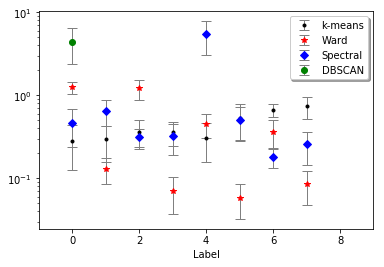

In [9]:
## Metrics of the solutions
np.random.seed(0)
labs = labels_k
qk = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_w
qw = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_s
qs = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_d
qd = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0)  

plt.yscale("log", nonposy='clip')
plt.xlim([-1,kCluster+1])
plt.errorbar(qk['label'],qk['Q'], qk['Q_err'], label='k-means',fmt='.k', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qw['label'],qw['Q'], qw['Q_err'], label='Ward', fmt='*r', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qs['label'],qs['Q'], qs['Q_err'], label='Spectral', fmt='Db', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qd['label'],qd['Q'], qd['Q_err'], label='DBSCAN', fmt='og', ecolor='gray', lw=1, capsize=5)
plt.legend(loc='upper right', shadow=True)
plt.xlabel("Label")
plt.show()

## Angular distance (1deg) : 10.0 pc


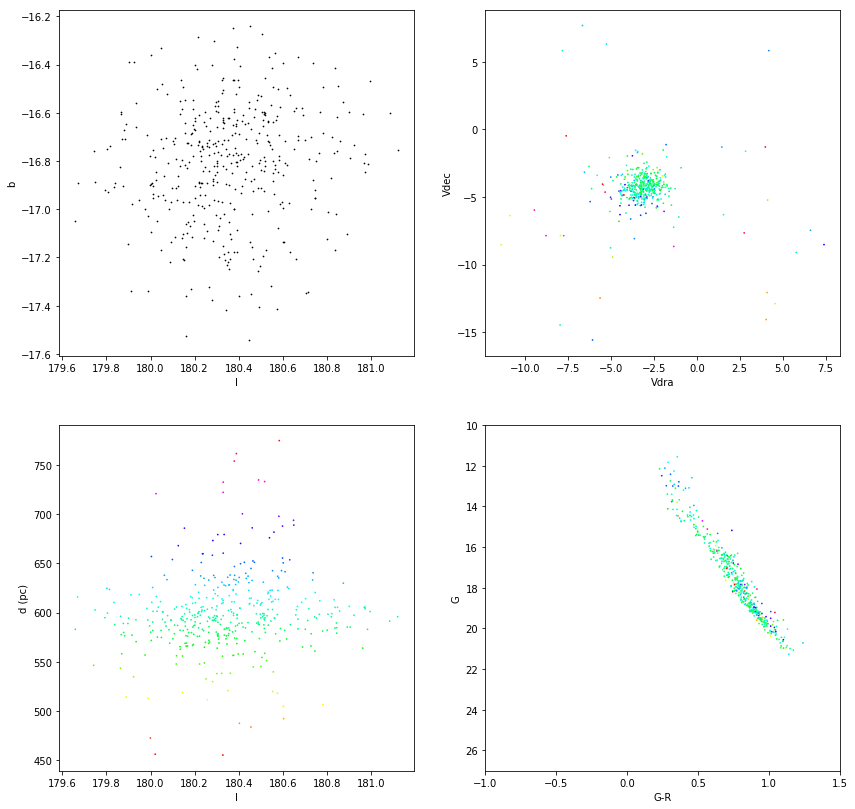

In [10]:
## separation distance
angl2pc = 3600. * 150e6 * distclust / 3.1e13
print("## Angular distance (1deg) : %3.1f pc"%(angl2pc))
plot2d(source.df, labels_d,0, cmap = "hsv")